<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Feature selection</h1>

## 1. Aims
<div class="alert alert-info">
To carry out feature selection on the leukaemia data.
</div>

## 2. Feature selection 
<div class="alert alert-info">
On the course webpage, you can download a (slightly reduced) version of the leukaemia data. It consists of some training data $X$ and associated labels $t$ as well as independent test data $X_{test}$ and $t_{test}$. Your task is to select some features and classify the data – in previous labs we have implemented code for classification and you may use whichever you like.
</div>

In [108]:
import scipy.io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs

leuk = scipy.io.loadmat('projection_files/labdata.mat')

In [58]:
X = leuk['X']
t = leuk['t'][:,0]
X_test = leuk['X_test']
t_test = leuk['t_test'][:,0]

<div class="alert alert-info">
Observe the class distribution of the data.
</div>

In [59]:
print("[TRAINSET]")
print("Data:  ", X.shape)
print("Labels:", t.shape)
print("Ratio leukaemia/healthy samples: %d/%d\n" % (len(t[t == 1]), len(t[t == 0])))

print("[TESTSET]")
print("Data:  ", X_test.shape)
print("Labels:", t_test.shape)
print("Ratio leukaemia/healthy samples: %d/%d" % (len(t_test[t_test == 1]), len(t_test[t_test == 0])))

[TRAINSET]
Data:   (38, 300)
Labels: (38,)
Ratio leukaemia/healthy samples: 11/27

[TESTSET]
Data:   (34, 300)
Labels: (34,)
Ratio leukaemia/healthy samples: 14/20


### 2.1 Feature selection 
<div class="alert alert-info">
You are free to use any of the feature selection schemes we covered – scoring the features, PCA, or clustering them (you should already have $k$-means code to do this). In each case, you should use the test set to investigate how performance varies as you change the number of features.</div>

#### 2.1.1 Scoring 
<div class="alert alert-info">
Use the scoring mechanism described in the lectures (only on the training data) to obtain a set of features (corresponding to a subset of the original ones). You should make sure you extract this subset from the test data too!
</div>

In [62]:
def compute_s(feature, t):
    
    mu1 = np.mean(feature[t])
    mu0 = np.mean(feature[np.logical_not(t)])
    
    var1 = np.var(feature[t])
    var0 = np.var(feature[np.logical_not(t)])
    
    return np.abs(mu1 - mu0) / (var0 + var1)


def order_features_by_score(X):
    
    scores = []
    
    for f in range(X.shape[1]):
        scores.append((f, compute_s(X[:,f], t)))
    
    scores.sort(key = lambda x: x[1], reverse=True)
    
    return np.array([x[0] for x in scores]), np.array([x[1] for x in scores])

In [65]:
ordered_features, scores = order_features_by_score(X)

print("Ordered features")
for i in range(10):
    print("Feature:", ordered_features[i], "\tScore:", scores[i])

Ordered features
Feature: 179 	Score: 6.427629171216177
Feature: 169 	Score: 5.668117244524391
Feature: 46 	Score: 5.563042819045604
Feature: 292 	Score: 5.563042819045593
Feature: 285 	Score: 4.555455072696275
Feature: 128 	Score: 4.113169417659932
Feature: 96 	Score: 3.1559210468356946
Feature: 9 	Score: 2.9400920302263946
Feature: 121 	Score: 2.9294014413297402
Feature: 236 	Score: 2.9044183540766753


<div class="alert alert-info">
Plot the data by considering the top 2 features and comment on the results.
</div>

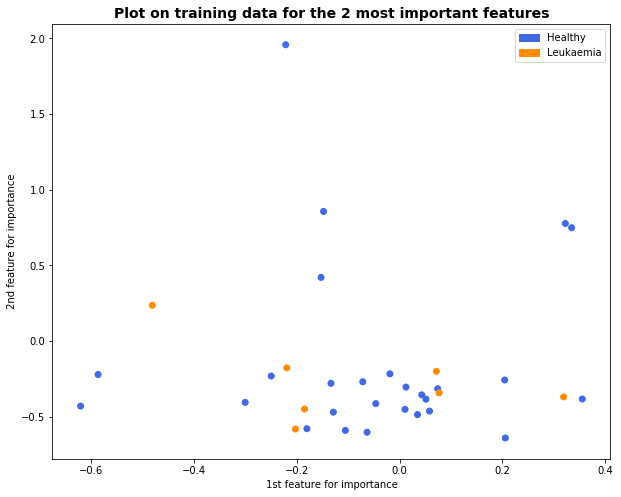

In [97]:
colour = ["royalblue", "darkorange"]
plt.figure(figsize=(10,8))
plt.scatter(X_test[:,ordered_features[0]], X_test[:,ordered_features[1]], c = [colour[t] for t in t])
plt.title("Plot on training data for the 2 most important features", fontsize=14, weight="semibold")
plt.xlabel("1st feature for importance")
plt.ylabel("2nd feature for importance")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

<div class="alert alert-info">
Does the visualisation of separate classes improve if you consider the top 3 features instead?</div>

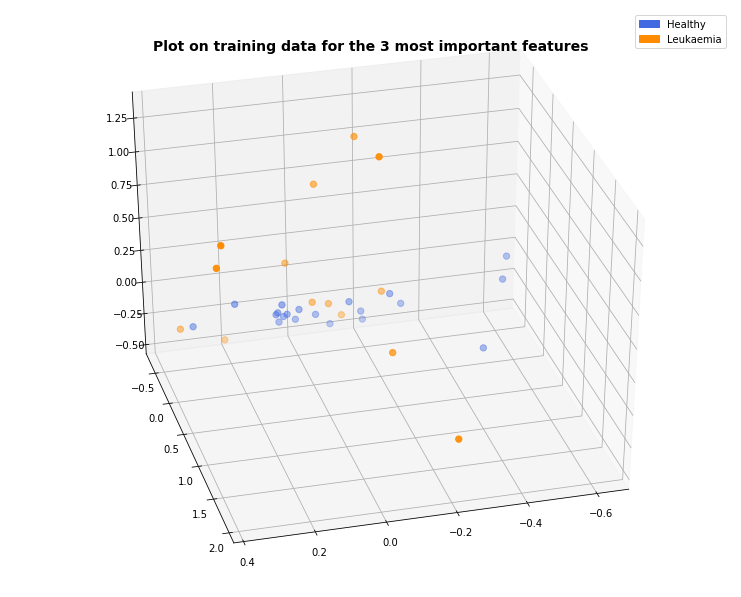

In [103]:
fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=35, azim=75)
plt.cla()
ax.scatter(X_test[:,ordered_features[0]], X_test[:,ordered_features[1]], \
           X_test[:,ordered_features[2]], c = [colour[t] for t in t_test], s=40)
plt.title("Plot on training data for the 3 most important features", fontsize=14, weight="semibold")
royalblue_patch = mpatches.Patch(color='royalblue', label='Healthy')
darkorange_patch = mpatches.Patch(color='darkorange', label='Leukaemia')
plt.legend(handles=[royalblue_patch, darkorange_patch])
plt.show()

#### 2.1.2 Clustering
<div class="alert alert-info">

You can use the $k$-means code you implemented in the previous notebook. Remember to pass the data the correct way around and only cluster the training data. Transforming the test data is a little more complex – your $k$-means should give you assignments of features to clusters. Use these alongside the test data to compute the cluster means for the test data (you do not need to re-assign the clusterings).

</div>

In [124]:
import math
from itertools import cycle, islice

def kmeans(X, k, maxiter, seed=None, centroids=None):
    
    # Initializations
    n = len(X[:,0])
    assignments = np.empty(n, dtype=int)
    
    # First random assignment
    np.random.seed(seed)
    centr_idx = np.random.choice(n,k,replace=False)
    centroids = np.array(X[centr_idx,:])
    
    # Main loop
    for t in range(0,maxiter):
        
        # ASSIGNMENT PHASE
        # Compute distance matrix
        dist_mat = pairwise_distances(X, centroids, metric='sqeuclidean')
        
        # Find minimum for each row
        assignments = np.argmin(dist_mat, 1);
        
       
        # UPDATE PHASE
        # Compute new centroids and update
        backup = np.copy(centroids)
        for c in range(0,k):
            centroids[c,0] = np.mean(X[assignments == c,0])
            centroids[c,1] = np.mean(X[assignments == c,1])
            
        # STOP CONDITION
        if np.all(centroids == backup):
            break
        
    return centroids, assignments

In [125]:
def runKmeans(k):
    # Run kmeans function
    maxiter = 20
    seed = None
    centroids, assignments = kmeans(X.T, k, maxiter, seed)
    
    return centroids, assignments

In [126]:
centroids, assignments = runKmeans(2)

In [127]:
print(centroids)

[[ 0.28491982 -0.03839234  0.36077985  0.38312261  0.2415616  -0.23643707
   0.48477033  0.91700552 -0.10452649 -0.68302562 -0.28051078 -0.23318664
   0.92183732  0.89992551  0.91482908  0.31319057  0.60374378 -0.24950273
  -0.04591346  0.45665552 -0.49417858  0.00242833 -0.01298531  0.83582675
   0.03006645  0.13586308  0.93180774 -0.46775929 -0.74375259 -0.39951909
  -0.53138304  0.42774769 -1.02361891 -0.39066903  0.01082504 -0.60399251
  -0.88543161 -1.00686832]
 [-0.45326949  0.09410598 -1.81482697 -0.64611124  0.94042126 -1.63473013
  -0.9544626  -0.84802315 -0.33289118 -0.40964976 -0.51019823  0.31151616
  -0.03135034  0.100774   -0.07816116 -0.22595772 -0.39003903 -0.43845622
  -0.42361963 -0.1028659   0.34202999  0.04492984 -1.62901498  0.01387395
  -0.83647484  0.23568155 -0.40896959  0.33838216  1.15156277  1.86074582
   0.92985204  0.66068351  0.86653036  0.9097608   0.27105009  1.4057995
   1.20626354  0.33708844]]


#### 2.1.3 Principal components
<div class="alert alert-info">
Implement a function for obtaining the $k$ principal components of your data.
Try to avoid using 'sklearn' libraries for this task!
</div>

In [ ]:
def pca_k(X, k):
    
    '''

    TO COMPLETE

    '''

<div class="alert alert-info">
As before, compare and contrast the effectiveness of using PCA when considering 2 and 3 principal components, respectively.<br>
Plot your results using scatter plots and comment on what you observe.
</div>

## 3. Classification
<div class="alert alert-info">
Insofar, we have only considered how carrying out dimensionality reduction allows us to _visually_ distinguish the different classes of the dataset.<br><br>

Using any of the classification algorithms we developed in the previous lectures, assess how classification performance varies when carrying out any of the above feature selection techniques as a preprocessing step. </div>